# Visualize Experiment Results

## Notebook Structure 

Experiment as parameter (Fully Observed, Corrupted, ...)

* Application Scenario 1 - Imputation Performance 
   * Categorical  Columns (Classification)
     * Evaluate `test`
   * Numerical Columns (Regression)
     * Evaluate `test`
   * Heterogenous Columns (Classification and Regression Combined)
     * Evaluate `test`
* Application Scenario 2 - Downstream Performance  
   * Categorical  Columns (Classification)
     * Evaluate `baseline`
     * Evaluate `corrupted`
     * Evaluate `imputed`
   * Numerical Columns (Regression)
     * Evaluate `baseline`
     * Evaluate `corrupted`
     * Evaluate `imputed`
   * Heterogenous Columns (Classification and Regression Combined)
     * Evaluate `baseline`
     * Evaluate `corrupted`
     * Evaluate `imputed`

## Dataset/Experiments Description

`test` = imputation performance  
`train` ignorieren

fully observed:
* `baseline` kriegt mean/mode für NaNs   
* `currupted`: test set wird currupted, dann mean/mode für NaNs, dann wird task ausgeführt  
* `imputed`: test set wird currupted, die entstehnden NaNs werden imputed, dann wird task ausgeführt

currupted:
* unterschied: train set wird currupted
* auf der basis wird basline trainiert
* rest bleibt gleich?
  * nicht ganz, currupted zwischenschritt fällt weg -> metriken=0

## Plots

* wichtig: wie gut ist imputation überhaupt
  * interpretierbare metriken (f1, rmse)
* robustheit: wie viele NaNs proudziert von imputern. 
  * ggf. reicht statisik / kein plot erforderlich.
  * GAIN produziert viele NaNs -> welcher rank?
* laufzeit (auch wenn fehleranfällig)
* einfluss auf downstream performance unter corruption
  * downstream vs clean (baseline)
* signifikanz tests, "multiple comparisons", https://de.wikipedia.org/wiki/Bonferroni-Korrektur
  * hypothese: imputation bringt was
* analyse auf task/columns ebene (allerdings wurden bisher untersch. cols gesampled)



## TODO

* plot corrupted
* add basline (line)
* check plots in other papers
* make import faster / pickle
* make sense of standard deviations?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

from pathlib import Path
from data_imputation_paper.experiment import read_experiment, read_csv_files

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Settings

In [2]:
sns.set(style="whitegrid")
sns.set_context('paper', font_scale=1.5)
mpl.rcParams['lines.linewidth'] = '2'

In [3]:
EXPERIMENT_PATH = Path("../data/experiments/cluster3/fully_observed/")
FIGURES_PATH = Path("../reports/figures/fully_observed/")

CLF_METRIC = "F1_macro"
REG_METRIC = "RMSE"

## Import the data

In [4]:
read_experiment(EXPERIMENT_PATH).head()

,experiment,imputer,task,missing_type,missing_fraction,strategy,file_or_dir,detail_file,path
0,fully_observed,AutoKerasImputer,737,MAR,0.01,single_all,impute_performance_mean_INCOME.csv,,../data/experiments/cluster3/fully_observed/Au...
1,fully_observed,AutoKerasImputer,737,MAR,0.01,single_all,downstream_performance_mean_INCOME.csv,,../data/experiments/cluster3/fully_observed/Au...
2,fully_observed,AutoKerasImputer,737,MAR,0.01,single_all,downstream_performance_std_INCOME.csv,,../data/experiments/cluster3/fully_observed/Au...
3,fully_observed,AutoKerasImputer,737,MAR,0.01,single_all,impute_performance_std_INCOME.csv,,../data/experiments/cluster3/fully_observed/Au...
4,fully_observed,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance_rep_2.csv,../data/experiments/cluster3/fully_observed/Au...


In [5]:
%%time

results = read_csv_files(read_experiment(EXPERIMENT_PATH))
results.drop("experiment", axis=1, inplace=True)
results.head()

CPU times: user 1min 2s, sys: 2.6 s, total: 1min 4s
Wall time: 1min 7s


,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed
0,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MAE,0.053787,0.259435,NaN,NaN,NaN
1,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MSE,0.004784,0.067306,NaN,NaN,NaN
2,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,RMSE,0.069168,0.259435,NaN,NaN,NaN
3,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MAE,0.063615,0.059506,NaN,NaN,NaN
4,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MSE,0.007851,0.003541,NaN,NaN,NaN


## Data wrangling

1. gruppieren nach allen experimental conditions und dann nur ueber alle repetitions schauen, was die ranks der einzelnen imputation methoden warn
2. diese ranks aggregieren

In [6]:
EXPERIMENTAL_CONDITIONS = ["task", "missing_type", "missing_fraction", "strategy", "column", "result_type", "metric"]

# erstmal mean/median o.ä. über reps => oder einfach die nicht detaillierten daten einlesn
# dann rank der imputer bilden

# die detailed ranks können nützlich sein für heterogene datasets

# TODO rank zum mitteln von numerical/categorical performance
ranked_data = results.groupby(EXPERIMENTAL_CONDITIONS).rank(ascending=False)
ranked_data = results.join(ranked_data, rsuffix="_rank")
ranked_data

,imputer,task,missing_type,missing_fraction,strategy,column,result_type,metric,train,test,baseline,corrupted,imputed,train_rank,test_rank,baseline_rank,corrupted_rank,imputed_rank
0,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MAE,0.053787,0.259435,NaN,NaN,NaN,12.0,7.0,NaN,NaN,NaN
1,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MSE,0.004784,0.067306,NaN,NaN,NaN,13.0,7.0,NaN,NaN,NaN
2,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,RMSE,0.069168,0.259435,NaN,NaN,NaN,13.0,7.0,NaN,NaN,NaN
3,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MAE,0.063615,0.059506,NaN,NaN,NaN,11.0,15.0,NaN,NaN,NaN
4,AutoKerasImputer,737,MAR,0.01,single_all,INCOME,impute_performance,MSE,0.007851,0.003541,NaN,NaN,NaN,11.0,15.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45895,GAINImputer,4135,MNAR,0.10,single_all,MGR_ID,downstream_performance,F1_macro,NaN,NaN,0.674287,0.674308,0.674308,NaN,NaN,6.5,2.0,2.0
45896,GAINImputer,4135,MNAR,0.10,single_all,MGR_ID,downstream_performance,F1_weighted,NaN,NaN,0.938495,0.938719,0.938719,NaN,NaN,6.5,2.0,2.0
45897,GAINImputer,4135,MNAR,0.10,single_all,MGR_ID,downstream_performance,F1_micro,NaN,NaN,0.946445,0.945835,0.945835,NaN,NaN,6.5,10.5,10.5
45898,GAINImputer,4135,MNAR,0.10,single_all,MGR_ID,downstream_performance,F1_macro,NaN,NaN,0.674287,0.671689,0.671689,NaN,NaN,6.5,4.0,5.0


In [7]:
ranked_data[["test_rank", "baseline_rank", "corrupted_rank", "imputed_rank"]].describe()

,test_rank,baseline_rank,corrupted_rank,imputed_rank
count,21996.000000,22950.000000,22950.000000,22950.000000
mean,6.524550,6.614118,6.614118,6.614118
std,4.594012,3.904522,4.519182,4.519705
min,1.000000,2.000000,1.000000,1.000000
25%,3.000000,3.500000,3.000000,3.000000
50%,5.000000,6.500000,5.500000,5.500000
75%,9.000000,8.000000,9.500000,9.500000
max,18.000000,17.000000,18.000000,18.000000


## Application Scenario 1 - Imputation Accuracy

In [8]:
IMPUTE_RESULT_TYPE = "impute_performance"

Path(FIGURES_PATH/IMPUTE_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

IMPUTATION_VAL_COL = "test"

### 1.1) Categorical Columns (Classification)

### 1.2) Numerical Columns (Regression)

### 1.3) Heterogenous Columns (Classification and Regression Combined)

## Application Scenario 2 - Downstream Performance

In [9]:
DOWNSTREAM_RESULT_TYPE = "downstream_performance"

Path(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE).mkdir(parents=True, exist_ok=True)

In [10]:
DOWNSTREAM_BASELINE_VAL_COL = "baseline"
DOWNSTREAM_CORRUPTED_VAL_COL = "corrupted"
DOWNSTREAM_IMPUTED_VAL_COL = "imputed"

### 2.1) Categorical  Columns (Classification)

#### Evaluate `baseline`

#### Evaluate `corrupted`

#### Evaluate `imputed`


### 2.2) Numerical Columns (Regression)

#### Evaluate `baseline`

#### Evaluate `corrupted`

#### Evaluate `imputed`

### 2.3) Heterogenous Columns (Classification and Regression Combined)

#### Evaluate `baseline`

#### Evaluate `corrupted`

#### Evaluate `imputed`

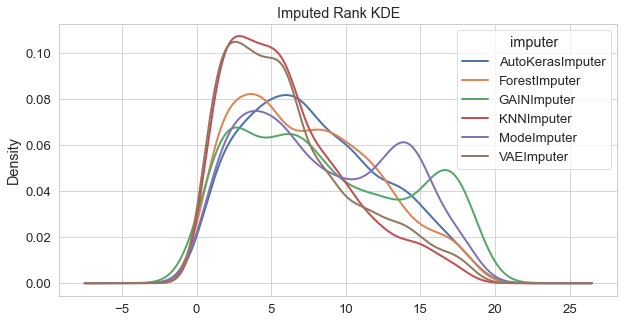

In [11]:
# TODO this needs to be changed

row_idx = (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & (results["metric"] == CLF_METRIC)

plot_data = ranked_data.loc[row_idx, ["imputer", "imputed_rank"]]
plot_data = plot_data.pivot(columns="imputer", values="imputed_rank")

plot_data.plot(kind="kde", title="Imputed Rank KDE", figsize=(10,5))
plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/"kde.svg")

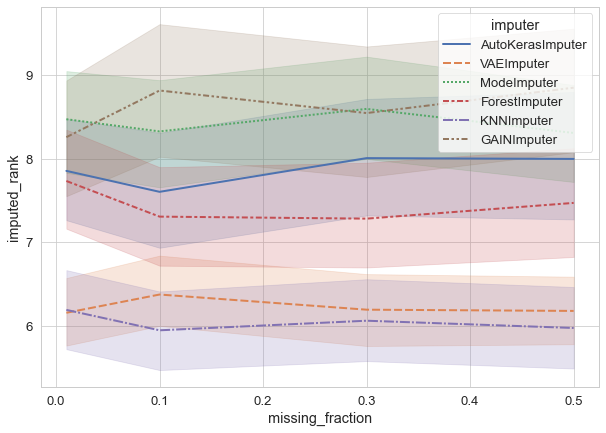

In [12]:
# TODO this needs to be changed

row_idx = (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & (results["metric"] == CLF_METRIC)

plot_data = ranked_data.loc[row_idx]

plt.figure(figsize=(10,7))
ax = sns.lineplot(
    data=plot_data, 
    x="missing_fraction", 
    y="imputed_rank", 
    hue="imputer", 
    style="imputer"
)
plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/"lineplot.svg")

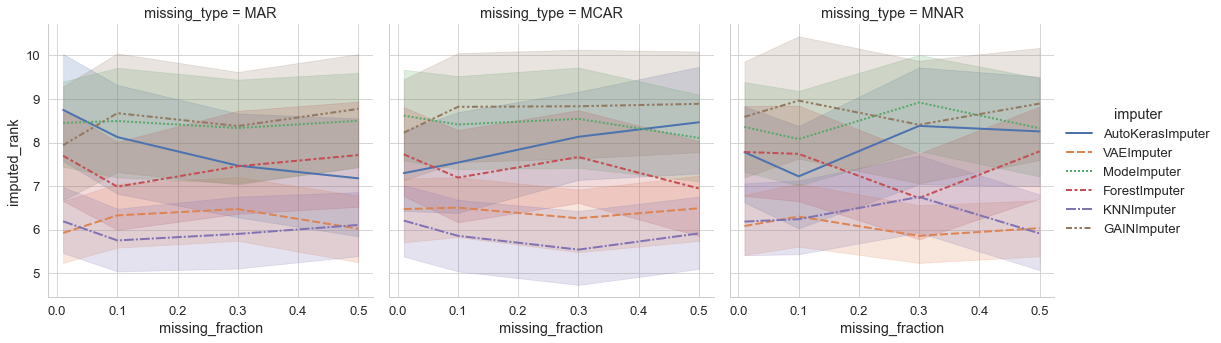

In [13]:
# TODO this needs to be changed

row_idx = (results["result_type"] == DOWNSTREAM_RESULT_TYPE) & (results["metric"] == CLF_METRIC)

plot_data = ranked_data[row_idx]

sns.relplot(
    data=plot_data, 
    x="missing_fraction", 
    y="imputed_rank", 
    hue="imputer", 
    style="imputer", 
    col="missing_type",
    kind="line",
)
plt.gcf().subplots_adjust(bottom=0.15, left=0.05) # avoid x/ylabel cutoff in SVG export
plt.savefig(FIGURES_PATH/DOWNSTREAM_RESULT_TYPE/"relplot.svg")